<a href="https://colab.research.google.com/github/tomasbelak24/deeplearning-vision/blob/main/HUPV/notebooks/cv03_en.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3 - Linear Classifier, Gradient Optimization

In this lab we will implement a simple linear classifier on synthetic 2D data.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

## Synthetic data

For the purposes of this lab, we will first work with synthetic data. We will generate them by assuming that the 2D data are from two normal distributions, while each of the two distributions corresponds to one class.

We will generate both training data and test data.

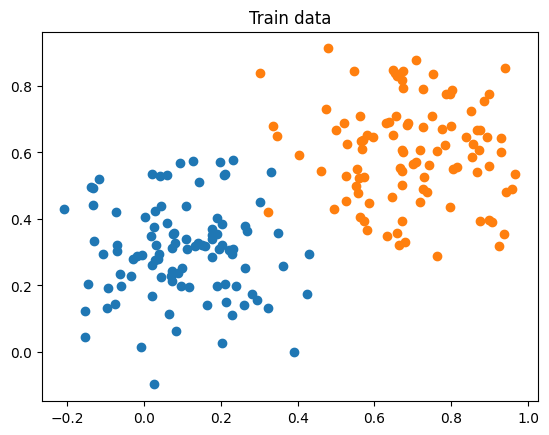

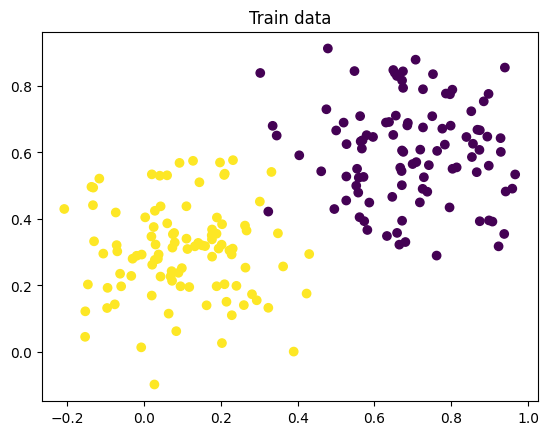

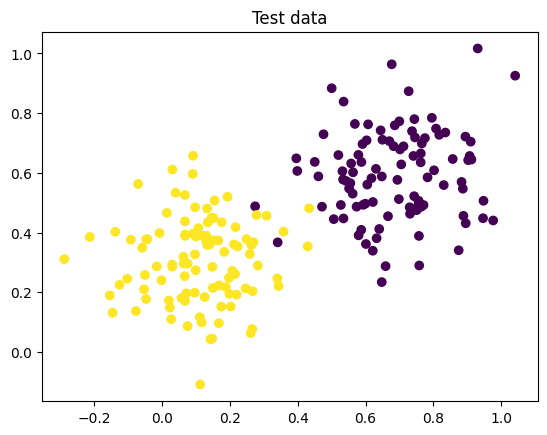

In [2]:
np.random.seed(11)

x1_center = np.array([0.1, 0.3])
x1 =  x1_center + 0.15 * np.random.randn(100, 2)

x2_center = np.array([0.7, 0.6])
x2 =  x2_center + 0.15 * np.random.randn(100, 2)

# while the classes are separated they are easy to plot
plt.scatter(x1[:, 0], x1[:, 1])
plt.scatter(x2[:, 0], x2[:, 1])
plt.title("Train data")
plt.show()

# we will modify the data to have vector x with data and y with labels
y = np.ones(200)
y[100:] = -1
x = np.concatenate([x1, x2], axis=0)

# we will also randomly permute the data
pindxs = np.random.permutation(200)
x = x[pindxs]
y = y[pindxs]

plt.scatter(x[:, 0], x[:, 1], c=y)
plt.title("Train data")
plt.show()

# we will also generate the test data
x1_test = x1_center + 0.15 * np.random.randn(100, 2)
x2_test =  x2_center + 0.15 * np.random.randn(100, 2)
y_test = np.ones(200)
y_test[100:] = -1
x_test = np.concatenate([x1_test, x2_test], axis=0)
pindxs = np.random.permutation(200)
x_test = x_test[pindxs]
y_test = y_test[pindxs]

plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test)
plt.title("Test data")
plt.show()

## Linear binary classifier

First, we will make the simplest so-called binary linear classifier.

We can perceive this classifier as a function $f: \mathbb{R}^n \mapsto \{-1, 1\}$. The input is the so-called feature vector. At the moment we will work with vectors from $\mathbb{R}^2$, so the input is represented by 2 real numbers. The output will be 1 if we classify the given vector as the first (positive) class and -1 if we classify the given input as the second (negative) class.

So the function $f$ is a classifier, but we don't yet know exactly what $f$ will look like. The classifier will have the form of:

$$ f = \text{sgn}(\vec{w}^T \vec{x} + b) = \text{sgn}\left(\sum_{i=1}^n w_i \cdot x_i + b\right),$$

where $\vec{w} \in \mathbb{R}^n$ (in our case $n = 2$), $b \in \mathbb{R}$ and $\text{sgn}$ is the signum function, which is defined as 1 for numbers higher than or equal to 0 and -1 otherwise. So we have a vector of weights $\vec{w}$ and bias $b$, which are the parameters of our model. Our goal will be to find $\vec{w}, b$ so that our classifier works as well as possible.

### Exercise 1 - Prediction

Implement the function which for the given parameters $\vec{w}$ and $b$ for the provided data. We want to return both the predicted classes and the accuracy, which is expressed as the proportion of correctly classified inputs.

To visualize the classifier, you can use the provided function that displays the straight line that divides the plane.


In [3]:
def display_binary_cls(x, y, w, b):
  if x.shape[1] != 2:
    raise TypeError("x has to represent 2-d points of shape (n, 2)")
  if y.shape[0] != x.shape[0]:
    raise TypeError("x and y have to have same number of rows")
  if w.shape[0] != 2:
    raise TypeError("w has to be an array of shape (2,) ")

  xmin = np.min(x[:, 0])
  xmax = np.max(x[:, 0])
  ymin = np.min(x[:, 1])
  ymax = np.max(x[:, 1])

  plt.xlim(xmin=xmin - 0.1, xmax=xmax + 0.1)
  plt.ylim(ymin=ymin - 0.1, ymax=ymax + 0.1)


  if w[1] == 0.0:
    plt.plot([-b / w[0], -b / w[0]], [ymin, ymax], c='black')
  else:

    ymin = (- w[0] * xmin - b) / w[1]
    ymax = (- w[0] * xmax - b) / w[1]

    plt.plot([xmin, xmax], [ymin, ymax], c='black')

  plt.scatter(x[:, 0], x[:, 1], c=y)
  plt.show()

Implement the `binary_cls(x, w, b)` function, which will have input data x and model parameters $\vec{w}$ and $b$ as input. At the output, it returns an array y, which will contain the classes as -1 or 1.

In [4]:
def binary_cls(x, w, b):
  y_pred = np.dot(x, w) + b
  y_pred = np.where(y_pred >= 0.0, 1.0, -1.0)
  return y_pred

Test the function on the manually selected parameters, which should give quite good accuracy (above 90 percent).

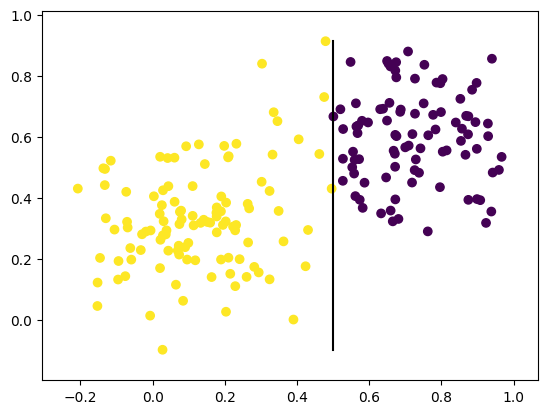

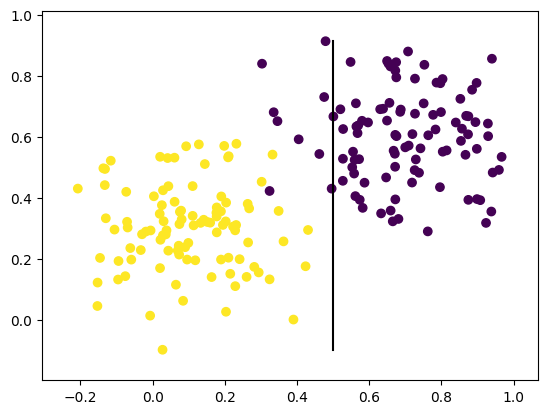

Accuracy of classifier:  0.955


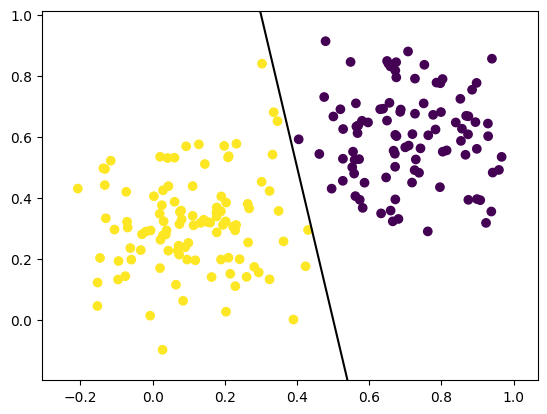

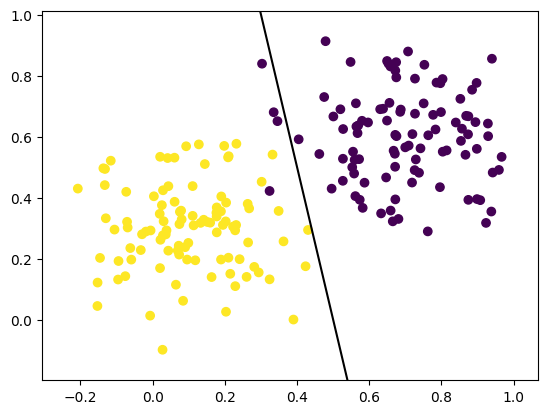

Accuracy of classifier:  0.98


In [6]:
w = np.array([-1.0,0.0])
b = 0.5

y_pred = binary_cls(x, w, b)
display_binary_cls(x, y_pred, w, b)
display_binary_cls(x, y, w, b)

acc = np.sum(y_pred == y)/len(y)
print("Accuracy of classifier: ", acc)

w = np.array([-1.0, -0.2])
b = 0.5

y_pred = binary_cls(x, w, b)
display_binary_cls(x, y_pred, w, b)
display_binary_cls(x, y, w, b)

acc = np.sum(y_pred == y)/len(y)
print("Accuracy of classifier: ", acc)

### Exercise 2 - Training

Manually estimated parameters are fine for 2D data, but it would be ideal to estimate them automatically, in a process in which the machine learns them (hence machine learning). We transform this problem into a standard optimization task. We will look for the parameters $\vec{w}$ and $b$ so as to minimize some function $L(\vec{w}, b, X, \vec{Y})$, where $X = (\vec{x}_1, \vec{x}_2,~...~\vec{x}_m)$ represents the input data and $\vec{Y} = (y_1, y_2,~...,~y_m)$ the annotations.

$L$ is also called a loss function and it can have different shapes. Today we will use this:

$$L(\vec{w}, b, X, \vec{Y}) = \frac{1}{m} \sum_{i = 1}^m \text{max}\left(0, 1 - y_i \left( \vec{w}^T \vec{x}_i + b\right)\right)$$

In order to find the optimal parameters, we will use gradient descent. It consists in the fact that we will estimate the parameters $\vec{w}$ and $b$ iteratively by first determining the random parameters and adjusting them based on the rules:

$$b^{n + 1} = b^n - \eta \frac{\partial L}{\partial b}(\vec{w}^n, b^n, X, \vec{Y})$$

$$w_j^{n + 1} = w_j^n - \eta \frac{\partial L}{\partial w_j}(\vec{w}^n, b^n, X, \vec{Y})$$,

where $\eta is the so-called step size. Of course we need to know the gradients:

$$\frac{\partial L}{\partial b}(\vec{w}_j^n, b^n, X, \vec{Y}) = \frac{1}{m} \sum_{i = 1}^m -z_i^n y_i,$$
$$\frac{\partial L}{\partial w_j}(\vec{w}_j^n, b^n, X, \vec{Y}) = \frac{1}{m} \sum_{i = 1}^m -z_i^n y_i x_{i, j},$$

where $x_{i, j}$ is the $j$-th component of the $i$-th vector from the training set X and

$$z_i^n = \begin{cases} 1,~if~\left(\vec{w}^{nT} \vec{x}_i + b\right) y_i < 1 \\ 0,~otherwise \end {cases}$$

Write a function `train_binary_cls(x, y, w_init, b_init, eta)` which will have $X, \vec{Y}, \vec{w}^0, b^0, \eta$ and the number of iteration steps $n$ as input and output returns $\vec{w}^n$ and $b^n$. In addition, it prints the value of the loss function at every hundredth step.

### Bonus exercise

As a bonus, you can try to derive gradients and implement them in the case when our loss function would also contain a regularization term, so:

$$L(\vec{w}, b, X, Y) = \frac{1}{m} \sum_{i = 1}^m \text{max}\left(0, 1 - y_i \left( \vec{w}^T \vec{x}_i + b\right)\right) + \lambda \sum_{i=1}^2 w_i^2$$

Then add the $\lambda$ parameter as an argument to the `train_binary_cls` function.

In [42]:
def compute_gradient_b(z, y):
  return np.mean(np.dot(-z, y))

def compute_gradient_w(z, y, x):
  z = np.atleast_2d(z)
  y = np.atleast_2d(y)
  x = np.atleast_2d(x)
  #print(f"shapes: {z.T.shape}, {y.shape}, {x.shape}")
  grad = np.mean(np.dot(-z.T, np.dot(y, x)), axis=0)
  #print(f"grad shape: {grad.shape}")
  return grad

def train_binary_cls(x, y, w_init, b_init, eta, n):
  # implement w, b update

  b = b_init
  w = w_init

  for i in range(n):
    z = np.where(y * (np.dot(x, w) + b) < 1.0, 1.0, 0.0)
    b_next = b - eta * compute_gradient_b(z, y)
    w_next = w - eta * compute_gradient_w(z, y, x)

    w = w_next
    b = b_next

    if n % 100 == 0:
      L = np.mean(np.maximum(0.0, 1.0 - y * (np.dot(x, w) + b)))
      print("At step: {} loss: {}".format(n, L))

  return w, b

We can test the code.



Streaming output truncated to the last 5000 lines.
At step: 5000 loss: 0.7439192780215381
At step: 5000 loss: 0.6264043470867245
At step: 5000 loss: 0.40668388406914374
At step: 5000 loss: 0.29036496266087036
At step: 5000 loss: 0.2051107721872232
At step: 5000 loss: 0.17055996819272992
At step: 5000 loss: 0.14389808933381987
At step: 5000 loss: 0.12746735361583283
At step: 5000 loss: 0.11144029166479193
At step: 5000 loss: 0.09964803675978277
At step: 5000 loss: 0.09193560144356618
At step: 5000 loss: 0.08378236949124382
At step: 5000 loss: 0.07822461231354516
At step: 5000 loss: 0.07378319746247039
At step: 5000 loss: 0.07056297313316533
At step: 5000 loss: 0.0660974550446024
At step: 5000 loss: 0.06355008017453927
At step: 5000 loss: 0.06195338058764383
At step: 5000 loss: 0.06066110402624404
At step: 5000 loss: 0.05929208102633516
At step: 5000 loss: 0.058367454128971014
At step: 5000 loss: 0.057361974207901255
At step: 5000 loss: 0.056390115016295025
At step: 5000 loss: 0.05529236

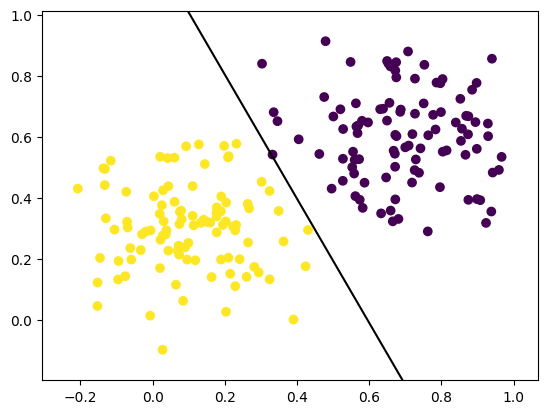

Accuracy of classifier on training data:  0.99


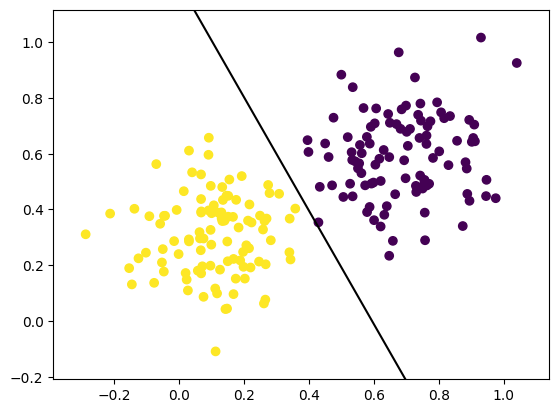

Accuracy of classifier on test data data:  0.98


In [43]:
w_train, b_train = train_binary_cls(x, y, np.array([0.0, 0.5]), -1.0, 1e-2, 5000)
print(w_train, b_train)

y_pred = binary_cls(x, w_train, b_train)
display_binary_cls(x, y_pred, w_train, b_train)
acc = np.sum(y_pred == y)/len(y)
print("Accuracy of classifier on training data: ", acc)


y_pred_test = binary_cls(x_test, w_train, b_train)
display_binary_cls(x_test, y_pred_test, w_train, b_train)
acc_test = np.sum(y_pred_test == y_test)/len(y)
print("Accuracy of classifier on test data data: ", acc_test)

## Pytorch - automatic gradients

With a simple linear classifier, we knew how to implement gradients for the purpose of optimization by hand. Of course, it would be more difficult for more complicated models. Therefore, we will now see how it is possible to use the PyTorch framework and calculate the gradient automatically.

At its core, PyTorch operates on tensors very similarly to NumPy. However, PyTorch additionally calculates intermediate calculations so that gradients can be calculated and is also optimized for GPU calculations. In addition, the framework is very "pythonic", which can generally be considered an advantage.

In [44]:
import torch
from torch.autograd import Variable

A tensor can be created from numpy using `torch.from_numpy`, or via the `torch.Tensor` constructor. Similarly, variables can be created. It is often necessary to pay attention to the type that the given vector has. It can be retyped using the type method. Sometimes, however, it is enough to retype it directly into numpy.

In [45]:
a = torch.from_numpy(np.array([4, 6, 7, 9]))
print(a)
print(a.shape)
print(a.type())
b = torch.from_numpy(np.array([[4, 6, 7, 9], [1, 1, 1, 1] ]))
print(b)
print(b.shape)
print(b.type())
bb = b.type(torch.FloatTensor)
print(bb.type())


c = torch.from_numpy(np.array([[4, 6, 7, 9], [1, 1, 1, 1] ], dtype=np.float32))
print(c)
print(c.shape)
print(c.type())

d = torch.Tensor([1,0,4])
print(d)
print(d.type())

e = torch.Tensor([1,0,4]).type(torch.LongTensor)
print(e)
print(e.type())

tensor([4, 6, 7, 9])
torch.Size([4])
torch.LongTensor
tensor([[4, 6, 7, 9],
        [1, 1, 1, 1]])
torch.Size([2, 4])
torch.LongTensor
torch.FloatTensor
tensor([[4., 6., 7., 9.],
        [1., 1., 1., 1.]])
torch.Size([2, 4])
torch.FloatTensor
tensor([1., 0., 4.])
torch.FloatTensor
tensor([1, 0, 4])
torch.LongTensor


It is also possible to convert back mainly using the `numpy()` method.


In [46]:
dn = d.numpy()
print(dn)
print(type(dn))
print(dn.shape)

[1. 0. 4.]
<class 'numpy.ndarray'>
(3,)


Like a numpy array, a torch Tensor can also be indexed. If we have a tensor with only one element, we can get it using the `item` method.

In [47]:
r = torch.from_numpy(np.random.rand(10, 4, 5))


print(r[0, 0, 0])
print(r[:, 1])
print(r[1:3, :, 0])
print(r[::2, 0, 1:4])

print(r[0, 0, 0].item())
print(type(r[0, 0, 0]))
print(type(r[0, 0, 0].item()))


tensor(0.0974, dtype=torch.float64)
tensor([[0.6323, 0.7324, 0.5328, 0.9185, 0.0697],
        [0.3859, 0.4914, 0.7534, 0.2725, 0.8514],
        [0.6957, 0.7258, 0.6996, 0.9706, 0.8613],
        [0.3766, 0.7910, 0.1675, 0.2539, 0.5375],
        [0.4619, 0.8787, 0.7478, 0.0297, 0.1948],
        [0.4273, 0.5912, 0.6343, 0.4327, 0.8512],
        [0.4796, 0.5718, 0.0427, 0.9734, 0.8586],
        [0.2165, 0.7318, 0.0751, 0.7804, 0.5254],
        [0.4423, 0.2371, 0.7308, 0.9499, 0.8423],
        [0.0468, 0.8886, 0.2325, 0.2100, 0.0064]], dtype=torch.float64)
tensor([[0.5752, 0.3859, 0.9189, 0.6061],
        [0.3751, 0.6957, 0.5232, 0.6622]], dtype=torch.float64)
tensor([[0.1374, 0.4940, 0.6875],
        [0.7878, 0.2281, 0.8697],
        [0.8157, 0.6389, 0.7300],
        [0.0800, 0.2401, 0.5659],
        [0.6258, 0.2123, 0.3753]], dtype=torch.float64)
0.09743909439945198
<class 'torch.Tensor'>
<class 'float'>


If we want to use the model of our classifier, we first create its variables. The forward function then returns the result before the signum function is applied.

We can test the model on some data. If we only want to make a prediction, then we have to let torch know that we don't need it to store the intermediate calculations for the gradient computation. Note that the inputs to the function are torch tensors. So a tensor is something on which torch can perform operations.

*Note:* Since we want to use vector operations, we assume that we will always input vectors in the form $N \times 2$, but $N$ can also be 1.

In [52]:
w = Variable(torch.randn(2).type(torch.FloatTensor), requires_grad=True)
b = Variable(torch.randn(1).type(torch.FloatTensor), requires_grad=True)

def forward(x, w, b):
  return torch.tensordot(w, x, dims=[[0], [1]]) + b

def predict(x, w, b):
  return torch.where(forward(x, w, b) > 0.0, 1, -1)

with torch.no_grad():
  print(forward(torch.from_numpy(np.array([[0.5, 0.5]], dtype=np.float32)), w, b))
  print(forward(torch.from_numpy(np.array([[1.0, -0.5]], dtype=np.float32)), w, b))
  print(forward(torch.from_numpy(np.array([[-0.9, 4.4]], dtype=np.float32)), w, b))

  print(predict(torch.from_numpy(np.array([[0.5, 0.5]], dtype=np.float32)), w, b))
  print(predict(torch.from_numpy(np.array([[1.0, -0.5]], dtype=np.float32)), w, b))
  print(predict(torch.from_numpy(np.array([[-0.9, 4.4]], dtype=np.float32)), w, b))

tensor([1.3311])
tensor([-0.0527])
tensor([6.7638])
tensor([1])
tensor([-1])
tensor([1])


We can implement training very simply. First, we calculate the loss function. This will be a torch tensor and we can call its `backward` method, which will calculate the gradient for all intermediate steps.

At step: 0 loss: 1.2758461236953735
At step: 100 loss: 1.1123969554901123
At step: 200 loss: 0.9939526915550232
At step: 300 loss: 0.883620023727417
At step: 400 loss: 0.7734593152999878
At step: 500 loss: 0.6632993817329407
At step: 600 loss: 0.5544469952583313
At step: 700 loss: 0.47728732228279114
At step: 800 loss: 0.42139366269111633
At step: 900 loss: 0.3751205801963806
At step: 1000 loss: 0.33747780323028564
At step: 1100 loss: 0.30663034319877625
At step: 1200 loss: 0.27936840057373047
At step: 1300 loss: 0.2559189200401306
At step: 1400 loss: 0.23741981387138367
At step: 1500 loss: 0.2220490276813507
At step: 1600 loss: 0.20926019549369812
At step: 1700 loss: 0.1989315152168274
At step: 1800 loss: 0.19040977954864502
At step: 1900 loss: 0.1837172657251358
At step: 2000 loss: 0.1776406615972519
At step: 2100 loss: 0.17185093462467194
At step: 2200 loss: 0.16638696193695068
At step: 2300 loss: 0.16143730282783508
At step: 2400 loss: 0.1565355360507965
At step: 2500 loss: 0.15188

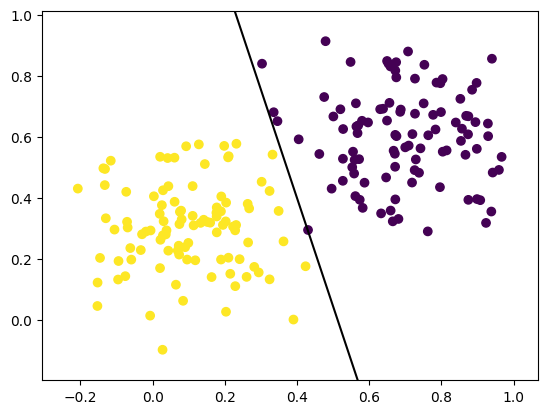

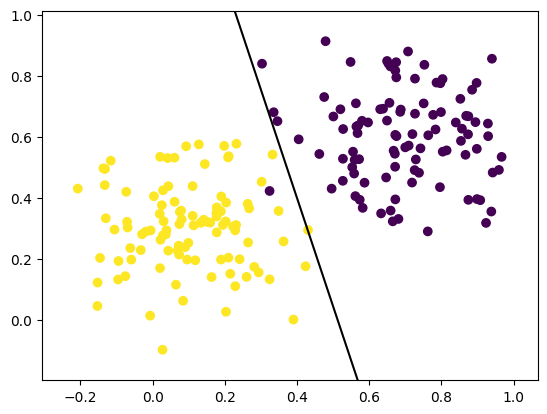

In [53]:
def train_torch_binary_cls(x, y, w, b, eps, n):
  x = torch.from_numpy(x).type(torch.FloatTensor)
  y = torch.from_numpy(y).type(torch.FloatTensor)

  for i in range(n):

    out = forward(x, w, b)
    loss = torch.mean(torch.clip(1 - out * y, min=0.0))

    if i % 100 == 0:
      print("At step: {} loss: {}".format(i, loss.item()))

    # we calculate the gradients
    loss.backward()

    # we perform the gradient update
    w.data -= eps * w.grad.data
    b.data -= eps * b.grad.data

    # now we have to reset the gradient as otherwise they would keep accumulating
    w.grad.data.zero_()
    b.grad.data.zero_()
  return w, b

w_trained, b_trained = train_torch_binary_cls(x, y, w, b, 1e-2, 5000)

y_pred = predict(torch.from_numpy(x).type(torch.FloatTensor), w, b).numpy()

display_binary_cls(x, y_pred, w.detach().numpy(), b.detach().numpy())
display_binary_cls(x, y, w.detach().numpy(), b.detach().numpy())


### Exercise 3 - Different loss function

The loss function we have used so far is not the only possible one. A suitable candidate is also the so-called binary cross entropy. In order to use it, we slightly modify the output from the classifier so that the output returns the probability that the given vector is from the first class, i.e. $f_p : \mathbb{R}^n \mapsto [0,1]$ and its form will be:

$$ f_p = \sigma \left(\vec{w}^T \vec{x} + b\right) = \sigma \left(\sum_{i=1}^n w_i x_i + b\right) = \sigma \left(z\right), $$ while the function $\sigma$ is defined as:

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

and when drawn it looks like this:

![plot of sigmoid](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/1920px-Logistic-curve.svg.png)

So it returns values from 0 to 1 and $y = \sigma (z) = \sigma(\vec{w}^T \vec{x} + b)$ so we can interpret it as the probability that the given vector $\vec{x }$ belongs to the positive class. Based on this interpretation, we can then use the binary cross-entropy as the loss function (binary cross-entropy):

$$L(\vec{w}, b, X, \vec{Y}) = -\frac{1}{m} \sum_{i = 1}^m y_i \text{log}\left(\sigma(\vec{ w}^T \vec{x}_i + b)\right) + (1 - y_i) \text{log}\left(1 - \sigma(\vec{w}^T \vec{x}_i + b )\right),$$

where $\vec{w}$ and $b$ are model parameters, $X$ is a $m \times n$ matrix that contains a vector from the training set on each row, and $\vec{Y}$ is a vector of classes, **but this time the first class will be marked as 1 and the second class as 0** (zero probability that the given element is from the first class).

So, implement the forward_bce, predict_bce and train_bce functions according to the structure as in the code above.

In [70]:
w = Variable(torch.randn(2).type(torch.FloatTensor), requires_grad=True)
b = Variable(torch.randn(1).type(torch.FloatTensor), requires_grad=True)

# we generate new data
y_bce = np.where(y > 0.0, 1.0, 0.0)

def forward_bce(x, w, b):
  # implement
  return torch.sigmoid(torch.tensordot(w, x, dims=[[0], [1]]) + b)

def predict_bce(x, w, b):
  # implement
  return torch.where(forward_bce(x, w, b) > 0.5, 1.0, 0.0)

with torch.no_grad():
  print(forward_bce(torch.from_numpy(np.array([[0.5, 0.5]], dtype=np.float32)), w, b))
  print(forward_bce(torch.from_numpy(np.array([[1.0, -0.5]], dtype=np.float32)), w, b))
  print(forward_bce(torch.from_numpy(np.array([[-0.9, 4.4]], dtype=np.float32)), w, b))

  print(predict_bce(torch.from_numpy(np.array([[0.5, 0.5]], dtype=np.float32)), w, b))
  print(predict_bce(torch.from_numpy(np.array([[1.0, -0.5]], dtype=np.float32)), w, b))
  print(predict_bce(torch.from_numpy(np.array([[-0.9, 4.4]], dtype=np.float32)), w, b))

tensor([0.5173])
tensor([0.4934])
tensor([0.7471])
tensor([1.])
tensor([0.])
tensor([1.])


At step: 0 loss: 0.9464706182479858
At step: 100 loss: 0.9096797704696655
At step: 200 loss: 0.876901388168335
At step: 300 loss: 0.8468376994132996
At step: 400 loss: 0.8187779784202576
At step: 500 loss: 0.7923301458358765
At step: 600 loss: 0.7672702670097351
At step: 700 loss: 0.7434616088867188
At step: 800 loss: 0.7208119034767151
At step: 900 loss: 0.699251651763916
At step: 1000 loss: 0.6787224411964417
At step: 1100 loss: 0.6591722369194031
At step: 1200 loss: 0.6405521631240845
At step: 1300 loss: 0.6228156089782715
At step: 1400 loss: 0.6059178709983826
At step: 1500 loss: 0.5898157358169556
At step: 1600 loss: 0.574467658996582
At step: 1700 loss: 0.5598337650299072
At step: 1800 loss: 0.5458757281303406
At step: 1900 loss: 0.53255695104599
At step: 2000 loss: 0.5198428630828857
At step: 2100 loss: 0.5077002048492432
At step: 2200 loss: 0.4960978031158447
At step: 2300 loss: 0.48500582575798035
At step: 2400 loss: 0.474396288394928
At step: 2500 loss: 0.46424275636672974
At

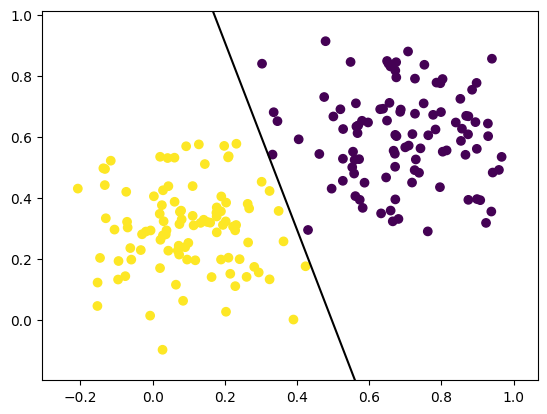

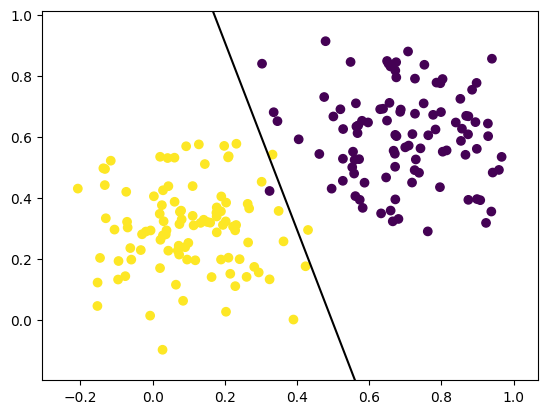

In [71]:
def train_torch_binary_cls(x, y, w, b, eps, n):
  # implement
  x = torch.from_numpy(x).type(torch.FloatTensor)
  y = torch.from_numpy(y).type(torch.FloatTensor)

  for i in range(n):

    out = forward_bce(x, w, b)
    #print(out)
    loss = torch.nn.functional.binary_cross_entropy(out, y)

    if i % 100 == 0:
      print("At step: {} loss: {}".format(i, loss.item()))

    # we calculate the gradients
    loss.backward()

    # we perform the gradient update
    w.data -= eps * w.grad.data
    b.data -= eps * b.grad.data

    # now we have to reset the gradient as otherwise they would keep accumulating
    w.grad.data.zero_()
    b.grad.data.zero_()
  return w, b


train_torch_binary_cls(x, y_bce, w, b, 1e-2, 5000)
train_torch_binary_cls(x, y_bce, w, b, 1e-3, 5000)

y_pred = predict(torch.from_numpy(x).type(torch.FloatTensor), w, b).numpy()

display_binary_cls(x, y_pred, w.detach().numpy(), b.detach().numpy())
display_binary_cls(x, y, w.detach().numpy(), b.detach().numpy())

### Bonus Exercise

Those who have finished everything can make a fully connected neural network instead of an ordinary linear classifier. For example if we add one more hidden layer, we get:

$$f_{c} = \sigma\left(\vec{w}_{out}^T \vec{\sigma}\left(W_{in} \vec{x} + \vec{b}_{in }\right) + b_{out}\right),$$

where $W_{in} \in \mathbb{R}^{h \times 2}$ is the $h \times 2$ weight matrix, $\vec{b}_{in} \in \mathbb{R}^{ h}$ is the bias vector applied after the first matrix, $w_{out} \in \mathbb{R}^{h}$ is the vector of weights with length $h$ and $b_{out} \mathbb{R}$ is the bias parameter, where $h$ is the number of hidden layer neurons and $\vec{\sigma}$ is the sigma function applied to each element of the vector separately.

If you manage to implement the function, you can try to add the regularization term for the weight vector and the weight matrix again. Thus, the loss will have the form:

$$L(\vec{w}, b, X, \vec{Y}) = -\frac{1}{m} \sum_{i = 1}^m y_i \text{log}\left(\sigma(\vec{ w}^T \vec{x}_i + b)\right) + (1 - y_i) \text{log}\left(1 - \sigma(\vec{w}^T \vec{x}_i + b )\right) + \lambda \left(\sum_{i, j} W_{in,i,j}^2 + \sum_{i} w_{out,i}^2 \right)$$

In [120]:
w_out = Variable(torch.randn(30).type(torch.FloatTensor), requires_grad=True)
b_out = Variable(torch.randn(1).type(torch.FloatTensor), requires_grad=True)

w_in = Variable(torch.randn(30, 2).type(torch.FloatTensor), requires_grad=True)
b_in = Variable(torch.randn(30).type(torch.FloatTensor), requires_grad=True)

# we generate labels
y_fc = np.where(y > 0.5, 1.0, 0.0)


def sigmoid(z):
  return 1 / (1 + torch.exp(-z))

def forward_fc(x, w_in, b_in, w_out, b_out):
  # implement
  a = torch.tensordot(w_in, x, dims=[[1], [1]]) + b_in.unsqueeze(-1)
  #print(a.shape)
  #print(w_out.shape)
  h = sigmoid(a)
  g = torch.tensordot(w_out, h, dims=[[0], [0]]) + b_out
  #print(g.shape)
  return sigmoid(g)

def predict_fc(x, w_in, b_in, w_out, b_out):
  # implement
  return torch.where(forward_fc(x, w_in, b_in, w_out, b_out) > 0.5, 1.0, 0.0)

with torch.no_grad():
  print(forward_fc(torch.from_numpy(np.array([[0.5, 0.5]], dtype=np.float32)),  w_in, b_in, w_out, b_out))
  print(forward_fc(torch.from_numpy(np.array([[1.0, -0.5]], dtype=np.float32)), w_in, b_in, w_out, b_out))
  print(forward_fc(torch.from_numpy(np.array([[-0.9, 4.4]], dtype=np.float32)), w_in, b_in, w_out, b_out))

  print(predict_fc(torch.from_numpy(np.array([[0.5, 0.5]], dtype=np.float32)), w_in, b_in, w_out, b_out))
  print(predict_fc(torch.from_numpy(np.array([[1.0, -0.5]], dtype=np.float32)), w_in, b_in, w_out, b_out))
  print(predict_fc(torch.from_numpy(np.array([[-0.9, 4.4]], dtype=np.float32)), w_in, b_in, w_out, b_out))

def train_torch_binary_fc(x, y, w_in, b_in, w_out, b_out, eps, n):
  # implement
  x = torch.from_numpy(x).type(torch.FloatTensor)
  y = torch.from_numpy(y).type(torch.FloatTensor)

  for i in range(n):
    out = forward_fc(x, w_in, b_in, w_out, b_out)
    loss = torch.nn.functional.binary_cross_entropy(out, y)
    loss.backward()

    w_out.data -= eps * w_out.grad.data
    b_out.data -= eps * b_out.grad.data

    w_in.data -= eps * w_in.grad.data
    b_in.data -= eps * b_in.grad.data

    w_out.grad.data.zero_()
    b_out.grad.data.zero_()
    w_in.grad.data.zero_()
    b_in.grad.data.zero_()

    if i % 100 == 0:
      print("At step: {} loss: {}".format(i, loss.item()))

  return w_in, b_in, w_out, b_out


train_torch_binary_fc(x, y_fc, w_in, b_in, w_out, b_out, 1e-2, 5000)
train_torch_binary_fc(x, y_fc, w_in, b_in, w_out, b_out, 1e-3, 5000)

y_pred = predict_fc(torch.from_numpy(x).type(torch.FloatTensor), w_in, b_in, w_out, b_out,).numpy()

print(np.sum(y_pred == y_fc)/len(y_fc))

#display_binary_cls(x, y_pred, w.detach().numpy(), b.detach().numpy())
#display_binary_cls(x, y, w.detach().numpy(), b.detach().numpy())

tensor([0.9778])
tensor([0.9706])
tensor([0.9877])
tensor([1.])
tensor([1.])
tensor([1.])
At step: 0 loss: 1.735561490058899
At step: 100 loss: 0.44959133863449097
At step: 200 loss: 0.3858049809932709
At step: 300 loss: 0.3628566861152649
At step: 400 loss: 0.3427266776561737
At step: 500 loss: 0.32467228174209595
At step: 600 loss: 0.3084050416946411
At step: 700 loss: 0.2936877906322479
At step: 800 loss: 0.2803209722042084
At step: 900 loss: 0.268136203289032
At step: 1000 loss: 0.2569906711578369
At step: 1100 loss: 0.24676260352134705
At step: 1200 loss: 0.23734772205352783
At step: 1300 loss: 0.22865641117095947
At step: 1400 loss: 0.22061127424240112
At step: 1500 loss: 0.21314510703086853
At step: 1600 loss: 0.20619963109493256
At step: 1700 loss: 0.19972366094589233
At step: 1800 loss: 0.1936725676059723
At step: 1900 loss: 0.18800683319568634
At step: 2000 loss: 0.18269166350364685
At step: 2100 loss: 0.17769621312618256
At step: 2200 loss: 0.17299312353134155
At step: 2300 